In [78]:
import pandas as pd
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [79]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
tests_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [ ]:
all_features = pd.concat((train_data.iloc[:,1:-1], tests_data.iloc[:, 1:]))
numeric_features_index = (all_features.dtypes[all_features.dtypes != 'object']).index
# 对数化+标准化
all_features[numeric_features_index] = (all_features[numeric_features_index].apply(lambda x: np.log1p(x))).apply(lambda x: (x-x.mean()) / x.std())
all_labels = np.log1p(train_data['SalePrice'])
all_mean_labels = np.mean(all_labels)
all_std_labels = np.std(all_labels)
all_labels = all_labels.apply(lambda x: (x-all_mean_labels) / all_std_labels)
# 缺失值
all_features[numeric_features_index] = all_features[numeric_features_index].fillna(0)
# 离散值
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)

train_features = torch.tensor(all_features[:len(train_data)].values, dtype=torch.float32).to("cuda")
tests_features = torch.tensor(all_features[len(train_data):].values, dtype=torch.float32).to("cuda")

train_labels = (torch.tensor(all_labels, dtype=torch.float32).to("cuda"))
train_labels = train_labels.reshape(train_labels.shape[0], 1)

# 反标准化->反对数化（log(1+x)的反函数exp(x)-1）
print(train_labels[0,0])
print(np.exp(train_labels[0,0] * all_std_labels + all_mean_labels) - 1)

tensor(0.5601, device='cuda:0')
208504.74869089492


In [129]:
class Net(nn.Module):
    """Regression Model

    Args:
        nn (nn.Module): PyTorch Module
    """
    def __init__(self):
        """init net struct
        """
        super().__init__()
        # self.dropout = nn.Dropout(0.001)
        # self.outputs = nn.Linear(all_features.shape[1], 1)
        linear = nn.Linear(all_features.shape[1], 1)
        nn.init.normal_(linear.weight, mean=0, std=0.01)
        nn.init.zeros_(linear.bias)
        self.outputs = nn.Sequential(linear)
    
    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """前向传播

        Args:
            features (torch.Tensor): features

        Returns:
            torch.Tensor: labels
        """
        return self.outputs(features)

In [82]:
loss  = nn.MSELoss()

In [83]:
def train(net: nn.Module, features: torch.Tensor, labels: torch.Tensor, num_epochs: int, lr: float, weight_decay: float, batch_size: int) -> np.array:
    """模型训练

    Args:
        features (torch.Tensor): features
        labels (torch.Tensor): labels
        num_epochs (int): 迭代次数
        lr (float): 学习率
        weight_decay (float): 暂退率
        batch_size (int): 批次大小

    Returns:
        torch.Tensor: 损失
    """
    is_training = net.training
    net.to("cuda")
    
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    dataset = torch.utils.data.TensorDataset(features, labels)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_training)
    
    train_losses = []
    
    tqdm_instance = tqdm(range(num_epochs), desc="训练中")
    for _ in tqdm_instance:
        # 训练模式
        net.train()
        train_loss = 0.0
        for X, y in data_loader:
            optim.zero_grad()
            l: torch.Tensor = loss(net(X), y)
            l.backward()
            optim.step()
            train_loss += l.item()
        train_losses.append(train_loss/num_epochs)
        tqdm_instance.set_postfix(loss=train_loss/num_epochs)
    return train_losses

In [107]:
def pred(net: nn.Module, features: torch.Tensor, labels: torch.Tensor) -> tuple[list[float], list[float]]:
    """预测

    Args:
        net (nn.Module): 模型
        features (torch.Tensor): 特征
        labels (torch.Tensor): 标签（用于计算损失）

    Returns:
        float: 损失值
    """
    net.to("cuda")
    net.eval()
    predes, losses = [], []
    if labels != None:
        dataset = torch.utils.data.TensorDataset(features, labels)
        data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)
        for feature, label in data_loader:
            pred = net(feature)
            loss_val: torch.Tensor = loss(pred, label)
            predes.append(pred.item())
            losses.append(loss_val.item())
        return predes, losses
    else:
        for feature in features:
            pred = net(feature)
            predes.append(np.exp(pred.item() * all_std_labels + all_mean_labels) - 1)
        return predes, losses

训练中:   0%|          | 0/100 [00:00<?, ?it/s]

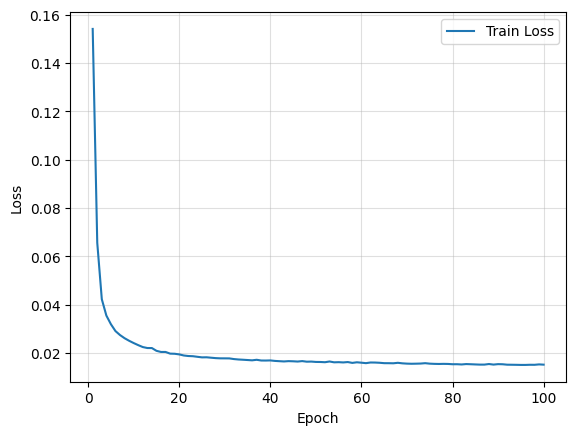

[119985.59678090943, 158846.6610590618, 186110.55566384655, 200140.57795323618, 201217.5421722729, 168919.5187457476, 178692.50688123977, 161680.28233188798, 195290.95958455032, 121649.3613947531, 171033.91310097408, 96649.7807231469, 95515.88585400268, 143773.3265796432, 101871.36835674143, 360896.4941060269, 246923.87854841436, 300697.3489943156, 307180.0540828151, 482285.0680659217, 348821.6964558815, 214859.66237340873, 182609.54368402273, 163014.72692009973, 197543.29207010777, 192780.23699587688, 353243.6575470715, 231916.68027385455, 191192.63874420043, 256546.812624356, 196286.65536609574, 97390.15234776206, 189764.6485353928, 306790.1188129343, 293370.5081714971, 239854.53465843888, 180621.9917249815, 188522.9721184165, 170499.3735121867, 161290.8074500642, 178808.65214385587, 142838.6918707674, 317438.9231374365, 242654.87816331408, 231376.0960877003, 190611.06268197024, 240216.017912186, 198223.19845299196, 159658.81282066467, 148734.40562439704, 165796.12996065797, 177014.7

In [130]:
net = Net()
train_losses = train(net=net, features=train_features, labels=train_labels, num_epochs=100, lr=0.001, weight_decay=0.001, batch_size=64)

plt.plot(list(range(1, 100+1)), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.4)
plt.legend(loc='upper right')
plt.show()

def create_submission() -> None:
    preds, _ = pred(net=net, features=tests_features, labels=None)
    print(preds)
    tests_data['SalePrice'] = pd.Series(preds)
    submission = pd.concat([tests_data['Id'], tests_data['SalePrice']], axis=1)
    submission.to_csv('submission_log_mlp.csv', index=False)
create_submission()

In [114]:
# K折交叉验证+网格搜索 寻找最佳参数
from skorch import NeuralNetRegressor # 二分类任务、回归任务
from sklearn.model_selection import GridSearchCV, train_test_split

def k_fold() -> None:
    model = NeuralNetRegressor(
        module=Net(),
        criterion=nn.MSELoss(),
        optimizer=torch.optim.Adam,
        lr=0.001,
        max_epochs=100,
        device="cpu"
    )

    param_grid = {
        'batch_size': [30, 60, 90, 120],
        'max_epochs': [50, 100, 150, 200],
        'lr': [0.001, 0.01, 0.1, 0.5]
    }

    # 创建GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,                  # estimator object（模型对象，由NeuralNetBinaryClassifier转换而来）
        param_grid=param_grid,            # dict或list of dicts，用于定义超参的搜索空间
        cv=5,                             # 交叉验证的折数或策略（默认为K折交叉验证）
        scoring='neg_mean_squared_error', # 定义模型评估指标
    )

    grid_search.fit(train_features.to("cpu"), train_labels.to("cpu"))

    print("最佳超参数：", grid_search.best_params_)
    print("最佳准确率：", grid_search.best_score_)
k_fold()

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3124        0.1853  0.0857
      2        0.1196        0.1502  0.0650
      3        0.0918        0.1461  0.0615
      4        0.0773        0.1460  0.0685
      5        0.0672        0.1461  0.0613
      6        0.0588        0.1450  0.0680
      7        0.0522        0.1439  0.0646
      8        0.0462        0.1430  0.0678
      9        0.0409        0.1410  0.0848
     10        0.0364        0.1410  0.0778
     11        0.0329        0.1394  0.0712
     12        0.0295        0.1370  0.0815
     13        0.0275        0.1359  0.1199
     14        0.0265        0.1364  0.1458
     15        0.0262        0.1383  0.1455
     16        0.0282        0.1386  0.1215
     17        0.0286        0.1598  0.1490
     18        0.0362        0.1935  0.1145
     19        0.0475        0.2263  0.1166
     20        0.0719        0.1675  0.1608
     21        0.0438        0.1

In [131]:
# 自定义K折交叉验证
def get_k_fold(k: int, i: int, X: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """获取第k个fold的训练集

    Args:
        k (int): 总折数
        i (int): 第i折
        X (torch.Tensor): 训练集总features
        y (torch.Tensor): 训练集总labels

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: 训练集features、训练集labels、测试集features、测试集labels
    """
    assert k > 1
    # 计算fold size
    fold_size = X.shape[0] // k # 根据训练集总样本数除以fold数取整计算得到一个fold的大小
    train_features, train_labels = None, None
    for j in range(k):
        # 需要生成k折数据集，并且将当前第i折作为测试集，其余均为训练集
        index = slice(j*fold_size, (j+1)*fold_size) # 划分每一折的数据集其实位置和结束位置
        
        features_part, labels_part = X[index, :], y[index] # 即Part of dataset to every single fold
        if j == i:
            # 此时为第i折，需要将其作为测试集
            test_features, test_labels = features_part, labels_part
        elif train_features == None:
            # 还未向训练集fold中添加过数据
            train_features, train_labels = features_part, labels_part # 添加第一批测试集
        else:
            # 添加剩余fold集合到训练fold中
            train_features = torch.cat([train_features, features_part], 0)
            train_labels = torch.cat([train_labels, labels_part], 0)
    return train_features, train_labels, test_features, test_labels # 这里是一组完整的训练集和测试集，只是均从原始训练集中划分
            
def self_k_fold(k: int, X_train: torch.Tensor, y_train: torch.Tensor, num_epochs: int, learning_rate: float, weight_decay: float, batch_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    """自定义K折交叉验证 不含网格搜索，仅观察损失变化趋势

    Args:
        k (int): _description_
        X_train (torch.Tensor): _description_
        y_train (torch.Tensor): _description_
        num_epochs (int): _description_
        learning_rate (float): _description_
        weight_decay (float): _description_
        batch_size (int): _description_

    Returns:
        tuple[torch.Tensor, torch.Tensor]: _description_
    """
    
    train_l, tests_l = [], []
    
    for i in range(k):
        # 进行第i折交叉验证
        train_features, train_labels, tests_features, tests_labels = get_k_fold(k=k, i=i, X=X_train, y=y_train)
        net = Net()
        net.train()
        train_losses = train(net=net, features=train_features, labels=train_labels, num_epochs=num_epochs, lr=learning_rate, weight_decay=weight_decay, batch_size=batch_size)
        net.eval()
        preds, tests_losses = pred(net=net, features=tests_features, labels=tests_labels)
        
        train_l.append(np.mean(train_losses))
        tests_l.append(np.mean(tests_losses))
    return train_l, tests_l
train_l, tests_l = self_k_fold(k=5, X_train=train_features, y_train=train_labels, num_epochs=50, learning_rate=0.001, weight_decay=0.001, batch_size=60)

训练中:   0%|          | 0/50 [00:00<?, ?it/s]

训练中:   0%|          | 0/50 [00:00<?, ?it/s]

训练中:   0%|          | 0/50 [00:00<?, ?it/s]

训练中:   0%|          | 0/50 [00:00<?, ?it/s]

训练中:   0%|          | 0/50 [00:00<?, ?it/s]

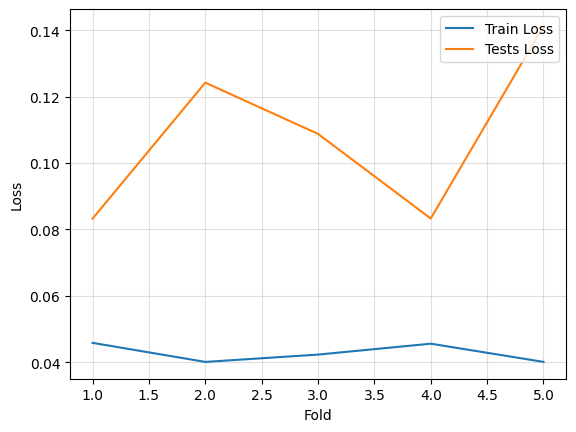

In [132]:
plt.plot(list(range(1, 5+1)), train_l, label='Train Loss')
plt.plot(list(range(1, 5+1)), tests_l, label='Tests Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True, alpha=0.4)
plt.legend(loc='upper right')
plt.show()